In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
import random
random.seed(0)

from utils import *
from usad import *

In [2]:
pth = './SIM'
ROOT_DIR = pth
dataset_folder = 'data/processed_sim_data'
columns = ['agent_id', 'latitude', 'longitude', 'time', 'stay_minutes']
baseline = pd.DataFrame(np.load(os.path.join(ROOT_DIR, 'baseline/data_stays_v2.npy'), allow_pickle=True), columns=columns)
kitware = pd.DataFrame(np.load(os.path.join(ROOT_DIR, 'kitware/data_stays_v2.npy'), allow_pickle=True), columns=columns)
l3harris = pd.DataFrame(np.load(os.path.join(ROOT_DIR, 'l3harris/data_stays_v2.npy'), allow_pickle=True), columns=columns)

In [3]:
baseline['time'] = np.array([x.timestamp() for x in baseline['time']])
kitware['time'] = np.array([x.timestamp() for x in kitware['time']])
l3harris['time'] = np.array([x.timestamp() for x in l3harris['time']])

In [4]:
win_size = 12

data_dims = 4
b9k1, k9l1, l9b1 = [], [], []
b9k1_tst, k9l1_tst, l9b1_tst = [], [], []
b9k1_labels, k9l1_labels, l9b1_labels =[],[],[]

timegap = 1.4 * 86400
ids = list(set(baseline['agent_id']).intersection(kitware['agent_id']).intersection(l3harris['agent_id']))

In [5]:
for i in list(baseline): 
    baseline[i]=baseline[i].apply(lambda x: str(x).replace("," , "."))
baseline = baseline.astype(float)
for i in list(kitware): 
    kitware[i]=kitware[i].apply(lambda x: str(x).replace("," , "."))
kitware = kitware.astype(float)
for i in list(l3harris): 
    l3harris[i]=l3harris[i].apply(lambda x: str(x).replace("," , "."))
l3harris = l3harris.astype(float)

In [6]:
from sklearn import preprocessing


In [7]:
import warnings
warnings.filterwarnings('ignore')
def avg(t1, t2):
    return 0.3*t1+ 0.7*t2
train_test_split = 0.6
for k in range(len(ids)):
    i = ids[k]
    t = random.uniform(0, 14-1.4) * 86400
    info_column = ['latitude', 'longitude', 'time', 'stay_minutes']
    d1,d2,d3 = baseline.loc[baseline['agent_id']==i][info_column].reset_index(drop=True), kitware[kitware['agent_id']==i][info_column].reset_index(drop=True), l3harris[l3harris['agent_id']==i][info_column].reset_index(drop=True)
    t1,t2,t3 = d1.iloc[0]['time'] + t, d2.iloc[0]['time'] + t, d3.iloc[0]['time'] + t
    i1, i2, i3 = d1[(d1['time'] >= t1) & (d1['time'] < t1 + timegap)], d2[(d2['time'] >= t2) & (d2['time'] < t2 + timegap)], d3[(d3['time'] >= t3) & (d3['time'] < t3 + timegap)]

    d1['label'] = 0
    d2['label'] = 0
    d3['label'] = 0
    i1['label'] = 1
    i2['label'] = 1
    i3['label'] = 1

    mix1 = pd.concat([d1[(d1['time'] < t1)], i2, d1[(d1['time'] >= t1 + timegap)]], axis=0).reset_index(drop=True)
    mix2 = pd.concat([d2[(d2['time'] < t2)], i3, d2[(d2['time'] >= t2 + timegap)]], axis=0).reset_index(drop=True)
    mix3 = pd.concat([d3[(d3['time'] < t3)], i1, d3[(d3['time'] >= t3 + timegap)]], axis=0).reset_index(drop=True)

    d1, d2, d3 = mix1.iloc[0:int(train_test_split*len(mix1))], mix2.iloc[0:int(train_test_split*len(mix2))], mix3.iloc[0:int(train_test_split*len(mix3))]
    
    mix1, mix2, mix3 = mix1.iloc[int(train_test_split*len(mix1)):], mix2.iloc[int(train_test_split*len(mix2)):], mix3.iloc[int(train_test_split*len(mix3)):]

    b9k1_label = np.array(mix1['label'])
    k9l1_label = np.array(mix2['label'])
    l9b1_label = np.array(mix3['label'])

    scaler = preprocessing.MinMaxScaler()
    x = d1.values[:,:-1]
    x_scaled = scaler.fit_transform(x)
    tst_scaled = scaler.transform(mix1.values[:,:-1])
    d1 = np.array(x_scaled)
    mix1 = np.array(tst_scaled)

    scaler = preprocessing.MinMaxScaler()
    x = d2.values[:,:-1]
    x_scaled = scaler.fit_transform(x)
    tst_scaled = scaler.transform(mix2.values[:,:-1])
    d2 = np.array(x_scaled)
    mix2 = np.array(tst_scaled)

    scaler = preprocessing.MinMaxScaler()
    x = d3.values[:,:-1]
    x_scaled = scaler.fit_transform(x)
    tst_scaled = scaler.transform(mix3.values[:,:-1])
    d3 = np.array(x_scaled)
    mix3 = np.array(tst_scaled)

    # some label for one series: 1 or 0
    for j in range(len(d1) // win_size):
        b9k1.append(d1[win_size*j:win_size*(j+1)])
    for j in range(len(d2) // win_size):
        k9l1.append(d2[win_size*j:win_size*(j+1)])
    for j in range(len(d3) // win_size):
        l9b1.append(d3[win_size*j:win_size*(j+1)])
        
    for j in range(len(mix1) // win_size):
        b9k1_tst.append(mix1[win_size*j:win_size*(j+1)])
        b9k1_labels.append(b9k1_label[win_size*j:win_size*(j+1)])
    for j in range(len(mix2) // win_size):
        k9l1_tst.append(mix2[win_size*j:win_size*(j+1)])
        k9l1_labels.append(k9l1_label[win_size*j:win_size*(j+1)])
    for j in range(len(mix3) // win_size):
        l9b1_tst.append(mix3[win_size*j:win_size*(j+1)])
        l9b1_labels.append(l9b1_label[win_size*j:win_size*(j+1)])

In [8]:
pth = 'SIM/'
for i in ['b9k1', 'k9l1', 'l9b1']:
    np.save(pth + i+ '/' + i + '_train.npy', np.array(eval(i)))
    np.save(pth + i+ '/' + i + '_test.npy', np.array(eval(i + '_tst')))
    np.save(pth + i+ '/' + i + '_test_label.npy', np.array(eval(i + '_labels')))

In [9]:
choice = 'b9k1'
windows_normal = np.load('SIM/' + choice + '/' + choice + '_train.npy')
windows_attack = np.load('SIM/' + choice + '/' + choice + '_test.npy')

In [10]:
import torch.utils.data as data_utils

BATCH_SIZE =  64
N_EPOCHS = 40
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [11]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0657, val_loss2: 0.0661
Epoch [1], val_loss1: 0.0657, val_loss2: -0.0029
Epoch [2], val_loss1: 0.0689, val_loss2: -0.0271
Epoch [3], val_loss1: 0.0713, val_loss2: -0.0402
Epoch [4], val_loss1: 0.0756, val_loss2: -0.0499
Epoch [5], val_loss1: 0.0783, val_loss2: -0.0565
Epoch [6], val_loss1: 0.0768, val_loss2: -0.0588
Epoch [7], val_loss1: 0.0796, val_loss2: -0.0633
Epoch [8], val_loss1: 0.0827, val_loss2: -0.0679
Epoch [9], val_loss1: 0.0800, val_loss2: -0.0670
Epoch [10], val_loss1: 0.0820, val_loss2: -0.0701
Epoch [11], val_loss1: 0.0812, val_loss2: -0.0703
Epoch [12], val_loss1: 0.0829, val_loss2: -0.0727
Epoch [13], val_loss1: 0.0832, val_loss2: -0.0738
Epoch [14], val_loss1: 0.0837, val_loss2: -0.0747
Epoch [15], val_loss1: 0.0890, val_loss2: -0.0796
Epoch [16], val_loss1: 0.0863, val_loss2: -0.0781
Epoch [17], val_loss1: 0.0859, val_loss2: -0.0782
Epoch [18], val_loss1: 0.0873, val_loss2: -0.0801
Epoch [19], val_loss1: 0.0875, val_loss2: -0.0799
Epoch [20],

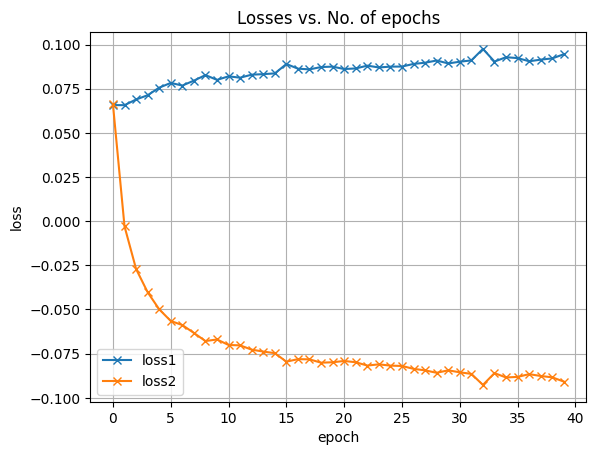

In [12]:
plot_history(history)

In [13]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

In [14]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [15]:
results=testing(model,test_loader)

In [16]:
windows_labels = np.load('SIM/' + choice + '/' + choice + '_test_label.npy')
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [17]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

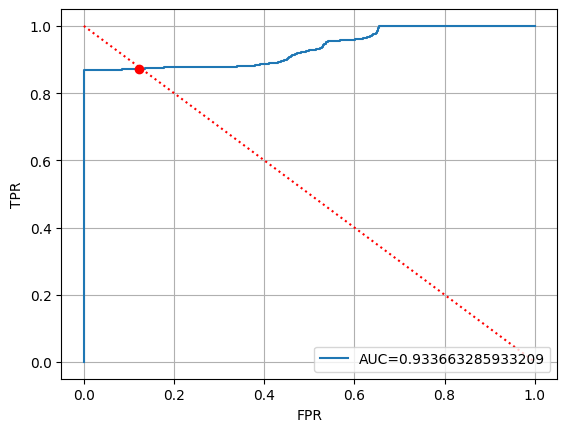

In [18]:
threshold=ROC(y_test,y_pred)